# Exercise Sheet 3: Neural Networks 2

In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
import Exercise3helper37 as helper

## Task 1: Backpropagation in MLPs (5 points - programming)

Construct a class "MLP" with a list of layers of type "MLPlayer" called "MLP.layers" Also, there should be a method "MLP.out(x)" that returns the outputs of the whole network of the input vector "x".

Make sure, that the size of the weight vector is set to the number of inputs for the first layer and that the number of inputs for the following layers has to correspond with the number of neurons in the preceding layer. The number of outputs equals the number of neurons in the last layer.

* The init function takes the number of inputs *x* as an integer and the number of nodes for each layer as a list. The number of neurons per layer and the number of inputs should be passed to the initialization methods of an MLPlayer.

* Include the backpropagation training algorithm as a method "MLP.train()" into the class. The passed arguments should consist of the number of iterations (no stopping criteria in this case), the training input and the training output - both as function pointers - as well as the learning rate. It should iterate over the layers, which themselves iterate over their neurons. Deltas and W of the following layer will allways be the input to the previous.

* The function x_train has to produce a random array of inputs of size [NoInputs,] and o_train has to produce the corresponding target function output. x_train should work without an argument passed and the target training output $o$ should be calculated using only that vector $x$.

* The output of the method *train()* should consist of the sum-of-squares error within each iteration.

Do the same training on an XOR as in exercise sheet 2 task 5, using an architecture of 2 and then 3 neurons in the first layer and one output neuron in the second (you may use the sample solution code).

In [2]:
class MLP:

    def __init__(self, input_num, node_num, weight=np.random.randn, bias=np.random.randn, trafunc = helper.logistic, dtrafunc = helper.dlogistic):

        self.layers =[helper.MLPlayer(node_num[0],input_num, weight, bias, trafunc, dtrafunc)]
        for i in range(len(node_num)-1):
            self.layers+=helper.MLPlayer(node_num[i+1],node_num[i], weight, bias, trafunc, dtrafunc)
        
        
    def out(self, x):
        ret =self.layers[0].out(x)
        for i in range(1,len(self.layers)):
            ret =self.layers[i].out(ret)
        self.lastout =ret
        return self.lastout

    def train(self, iterations, x_train, o_train, learnrate = 0.1):
        err = np.zeros(iterations)
        
        for i in range(iterations):
            if callable(x_train):
                x = x_train()
            else:
                x = x_train[i]
            if callable(o_train):
                o = o_train(x)
            else:
                o = o_train[i]
                
            y = self.out(x)
            
            if isinstance(y,np.ndarray)==False:
                o =np.array([o])
                y =np.array([y])
                
            W = np.eye(len(y))  
            deltas =y - o
            
            
            
            for node in reversed(range(len(self.layers))):
                 deltas, W =self.layers[node].train(deltas, W, learnrate)               
            err[i] =np.sum((y - o)**2)/2

        return err

## Task 2 Lateral Inhibition  (3  points - programming)
Build a network layer representing the simple lateral inhibition we have faced in lecture 2. This involves only a direct neighbour supression. It represents a not fully-connected MLP layer. The layer should be 10 neurons wide with the same number of inputs.
Set the bias to $b=0$, the weights for the corresponding center input to 1 and the direct neighbour weights to $w=-0.25$. Later, repeat the simulation with $w=-0.5$.

As inputs, use a random vector of 0 and 1 (np.random.randint).

First solve the task with the logistic transfer function. Then use the sign-based transfer function and examine the results with plots of the input together with the corresponding output over their indices.

No training, deltas etc. are neccessary for this task.

In [3]:
class LateralInhibitionLayer:
    nodes = []

    def __init__(self, NodeNo, Neighbourweight, bias = 0, trafunc = helper.logistic):
        
        weights = np.eye(NodeNo) + (np.eye(NodeNo,k=1)*Neighbourweight) + (np.eye(NodeNo,k=-1)*Neighbourweight)
        self.nodes=[]
        for i in range(NodeNo):
            self.nodes+=neuron(weights[i, :], bias, trafunc, dtrafunc)

    def out(self, x):
        ret=[]
        for n in self.nodes:
            ret+=n.out(x)
        
        return ret

## Task 3 Lateral Inhibition: trained (2 points - programming)
Use the output of the lateral inhibition layer from task 1 as a target output for an MLP with 1 layer of 10 neurons.
Try out both tranfer functions for the lateral inhibition layer (target) but only the logistic for the MLP (the one we are training). Use $w=-0.25$ for the inhibition of the lateral inhibition layer.

As inputs, use again a random vector of 0 and 1 (np.random.randint).

Determine a number of iterations that you decide to be enough for the network to have converged.

Measure the execution time by using the python module time and time.time() to get the current time to compare it later to the one from task 4. Also, investigate the weights after initialization and after the last iteration.

If you haven't solved task 1, you can use the class *LateralInhibitionLayer(NodeNo,Neighbourweight,bias=0,trafunc=logistic)* from the Exercise3Helper with the method LateralInhibitionLayer.out(x) as the target function.

In [4]:
LayerNos=[10]
Network = MLP(10,LayerNos)
learnrate=1
NumIt=10

# Logistic
Log_LatInh = helper.LateralInhibitionLayer(NodeNo= 10, Neighbourweight= -0.25)
Log_LatInh_Output = Log_LatInh.out(x =np.random.randint(2, size = NumIt))
print(Log_LatInh_Output)
print(np.random.randint(2, size = 10))
Network.train(NumIt,x_train = lambda:np.random.randint(2,size=10), o_train =  Log_LatInh.out(np.random.randint(2, size = NumIt)) )

[0.5        0.5        0.5        0.4378235  0.6791787  0.62245933
 0.6791787  0.4378235  0.5        0.5       ]
[1 1 0 0 1 1 0 1 0 1]


array([0.53936296, 0.68656403, 0.7033096 , 0.71586495, 0.87182848,
       0.61850705, 0.42504787, 0.8350346 , 0.7321929 , 0.56197145])

## Task 4 Training a 1D-Convolutional NN on lateral inhibition (2 points - programming)

Use the output of the lateral inhibition layer as a target output for a CNN consisting of 1 layer with 10 neurons. The code for the CNNlayer class is given below. You can simnply abuse the MLP class and assign a single layer using the CNNlayer class with 3 weights (see code below). Use $w=-0.25$ for the inhibition in the lateral inhibiton layer.

As inputs, use again a random vector of 0 and 1 (np.random.randint).

Measure and compare the execution time to the one of the MLP trained on the same problem (Task 2) by using the python module time and time.time() to get the current time.  Use the same number of intializations. Also, investigate the weights after initialization and after the last iteration.

If you haven't solved task 2, you can use the class *LateralInhibitionLayer(NodeNo,Neighbourweight,bias=0,trafunc=logistic)* from the Exercise3Helper with the method LateralInhibitionLayer.out(x) as the target function.

In [5]:
class CNNlayer:
    def __init__(self,Filterwidth,weightinit=np.random.randn,biasinit=np.random.randn,trafunc=helper.logistic,dtrafunc=helper.dlogistic):        
        #self.nodes=[neuron(weightinit(WeightNo),biasinit(1),trafunc) for i in range(NodeNo)]
        self.w=weightinit(Filterwidth) 
        self.b=biasinit(1)
        self.trafunc=trafunc
        self.dtrafunc=dtrafunc
        
    def out(self,x):
        self.lastin=x;
        self.lasth=np.convolve(x,self.w,mode='same')-self.b
        self.lastout=self.trafunc(self.lasth)
        return self.lastout
    
    def delta(self,deltanext,weightsnext):
        df=self.dtrafunc(self.lasth)
        self.lastdelta=np.dot(deltanext,weightsnext)*df
        return self.lastdelta
    
    def train(self,deltanext,W,learnrate=0.1):        
        self.delta(deltanext,W)
        WE=np.eye(len(self.lastin))
        W=np.array([np.convolve(we,self.w,mode='same') for we in WE])
        self.w=np.array([self.w[i]-learnrate*np.sum(self.lastdelta*np.convolve(self.lastin,np.eye(len(self.w),1,-i).ravel(),mode='same')) for i in range(len(self.w))])
        self.b=self.b+learnrate*np.sum(self.lastdelta)        
        return

In [6]:
LayerNos=[10]
CNN=helper.MLP(10,LayerNos)
CNN.layers[0]=helper.CNNlayer(3)


## Task 5 Local Oscilations (3 points - programming)
Rewrite the neuron class below to receive a neuron with local feedback capable of oscillations. This will be a very simple example to demonstrate oscillations, biologically not very plausible as we e.g. don't include the refactory period.

To this extent, you need to save and feedback the last output in a certrain time interval. No training or delta functions are necessary.  Use the logistic function as the transfer function. The output function becomes:
$y(t)=f(w\cdot x(t)+w_\tau y(t-\tau)-b)$

Initialize a regular perceptron and a local feedback neuron with the same random weights. The input should be of shape (2,), randomly distributed with an average of 0.5 and a standard deviation of 0.2.
Repeat 200 iterations each with every possible combination of the following parameters: $\tau=\{10,5\}$ samples and $w_\tau=\{10,5,1,-1,-5,-10\}$ using exactly the same random input for each parameter set and interation.

Plot the output compared for every single parameter set.


[0.47180663 0.30611143]
(2, 6, 200, 2)


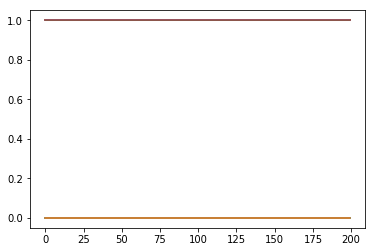

In [53]:
w_taus=[10,5,1,-1,-5,-10]
taus=[10,5]
numIt=200

class neuron:    
    lasth=0
    lastout=0
    lastin=0
    
    def __init__(self,w,b,tau,w_tau,trafunc=helper.logistic,dtrafunc=helper.dlogistic):
        self.w=np.array(w)
        self.b=np.array(b)
        self.tau=tau
        self.w_tau=w_tau
        self.trafunc=trafunc
        self.dtrafunc=dtrafunc
        
    def out(self, x):
        self.lastin=x;
        self.lasth=np.dot(self.w,x)+(self.w_tau*self.tau)-self.b
        self.lastout=self.trafunc(self.lasth)
        return self.lastout   
    
    
inp=np.random.normal(0.5,0.2,2)
print(inp)
neurons=[[[0 for x in range(numIt)] for y in range(len(w_taus))] for z in range(len(taus))]
for i in range(len(taus)):
    for j in range(len(w_taus)):
        neu=neuron(np.random.randint(2,size=2),np.random.randint(2,size=2),taus[i],w_taus[j])
        for a in range(numIt):
            neurons[i][j][a]=neu.out(np.random.normal(0.5,0.2,2))
neurons=np.array(neurons)
print(neurons.shape)
for i in range(len(w_taus)):
    plt.plot(neurons[0,i,:])

plt.show()
